In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("TensorFlow version:", tf.__version__)
print("GPU devices available:", tf.config.list_physical_devices('GPU'))
print("Device library list:")
print(device_lib.list_local_devices())


TensorFlow version: 2.15.0
GPU devices available: []
Device library list:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16467102861941474690
xla_global_id: -1
]


In [4]:
file_path = '../data/data.csv'
df = pd.read_csv(file_path, parse_dates=['Date'])
#df = df.dropna()
df

,Date,Inflation,CPI,Treasury_Yield,Open,High,Low,Close,SP500_Adj_Close,Volume,...,volatility,volatility_forcast,returns,EWMA_VM,GARCH_VM,EGARCH_VM,RogersSatchell_VM,garman_klass,parkinson,yang_zhang
0,2003-01-03,1.62,182.600,4.05,909.0300,911.2500,903.0700,908.5900,908.5900,1130800000,...,0.9058,2.5512,-0.0005,0.0116,0.0002,0.0182,0.0069,0.0064,0.0054,0.0090
1,2003-01-06,1.63,182.600,4.09,908.5900,931.7700,908.5900,929.0100,929.0100,1435900000,...,2.5512,1.1827,0.0222,0.0112,0.0003,0.0267,0.0086,0.0112,0.0151,0.0252
2,2003-01-07,1.62,182.600,4.04,929.0100,930.8100,919.9300,922.9300,922.9300,1545200000,...,1.1827,1.6085,-0.0066,0.0122,0.0003,0.0376,0.0070,0.0072,0.0071,0.0118
3,2003-01-08,1.71,182.600,4.00,922.9300,922.9300,908.3200,909.9300,909.9300,1467600000,...,1.6085,2.0199,-0.0142,0.0119,0.0004,0.0512,0.0053,0.0070,0.0096,0.0160
4,2003-01-09,1.78,182.600,4.19,909.9300,928.3100,909.9300,927.5700,927.5700,1560300000,...,2.0199,1.6597,0.0192,0.0121,0.0004,0.0675,0.0040,0.0076,0.0120,0.0200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,2024-06-24,2.22,313.049,4.25,5459.5801,5490.6602,5447.5898,5447.8701,5447.8701,3696750000,...,0.7906,0.4832,-0.0031,0.0055,0.0005,0.8196,0.0067,0.0054,0.0047,0.0079
5365,2024-06-25,2.22,313.049,4.23,5460.7300,5472.8799,5446.5601,5469.2998,5469.2998,3591960000,...,0.4832,0.5736,0.0039,0.0054,0.0005,0.8196,0.0035,0.0033,0.0029,0.0054
5366,2024-06-26,2.26,313.049,4.32,5460.7100,5483.1401,5451.8701,5477.8999,5477.8999,3563920000,...,0.5736,0.4256,0.0016,0.0053,0.0005,0.8196,0.0034,0.0035,0.0034,0.0059
5367,2024-06-27,2.26,313.049,4.29,5473.5898,5490.8101,5467.5400,5482.8701,5482.8701,3589530000,...,0.4256,1.3304,0.0009,0.0052,0.0005,0.8196,0.0028,0.0028,0.0026,0.0043


In [5]:
target = 'volatility_forcast'
date='Date'

df=df.drop(columns=[date])
X = df.drop(columns=[target])
y = df[target]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [9]:
print("Original X_train shape:", X_train.shape)  # (num_samples, num_features)

timesteps = 10

features = X_train.shape[1]

num_samples_train = (X_train.shape[0] - timesteps + 1) 
X_train_trimmed = X_train[:num_samples_train + timesteps - 1] 
X_train_lstm = np.array([X_train_trimmed[i:i+timesteps] for i in range(num_samples_train)]) 

num_samples_test = (X_test.shape[0] - timesteps + 1)
X_test_trimmed = X_test[:num_samples_test + timesteps - 1]
X_test_lstm = np.array([X_test_trimmed[i:i+timesteps] for i in range(num_samples_test)])

y_train_lstm = y_train[timesteps - 1:num_samples_train + timesteps - 1]
y_test_lstm = y_test[timesteps - 1:num_samples_test + timesteps - 1]

print("LSTM X_train shape:", X_train_lstm.shape)  # (num_samples, timesteps, features)
print("LSTM X_test shape:", X_test_lstm.shape)
print("LSTM y_train shape:", y_train_lstm.shape)  # (num_samples,)
print("LSTM y_test shape:", y_test_lstm.shape)


Original X_train shape: (4295, 22)
LSTM X_train shape: (4286, 10, 22)
LSTM X_test shape: (1065, 10, 22)
LSTM y_train shape: (4286,)
LSTM y_test shape: (1065,)


In [10]:
X_train_lstm

array([[[0.81818182, 0.78036364, 0.30801688, ..., 0.11710526,
         0.11609907, 0.09124629],
        [0.79461279, 0.64422584, 0.23839662, ..., 0.02763158,
         0.0371517 , 0.03486647],
        [0.62289562, 0.4197512 , 0.36075949, ..., 0.07236842,
         0.14551084, 0.11646884],
        ...,
        [0.56228956, 0.27311005, 0.47468354, ..., 0.06184211,
         0.06346749, 0.0504451 ],
        [0.64646465, 0.53583923, 0.53586498, ..., 0.05657895,
         0.05882353, 0.06083086],
        [0.57575758, 0.53716364, 0.47890295, ..., 0.22631579,
         0.24303406, 0.19510386]],

       [[0.79461279, 0.64422584, 0.23839662, ..., 0.02763158,
         0.0371517 , 0.03486647],
        [0.62289562, 0.4197512 , 0.36075949, ..., 0.07236842,
         0.14551084, 0.11646884],
        [0.53872054, 0.59216077, 0.02320675, ..., 0.25      ,
         0.35139319, 0.28115727],
        ...,
        [0.64646465, 0.53583923, 0.53586498, ..., 0.05657895,
         0.05882353, 0.06083086],
        [0.5

In [11]:
# LSTM Model
model = Sequential([
    #LSTM(1024, activation='relu', return_sequences=True, input_shape=(timesteps, features)),
    #BatchNormalization(),
    #Dropout(0.2),

    #LSTM(512, activation='relu', return_sequences=True),
    #BatchNormalization(),
    #Dropout(0.2),
    
    LSTM(256, activation='relu', return_sequences=True, input_shape=(timesteps, features)),
    BatchNormalization(),
    Dropout(0.1),
    
    LSTM(128, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.1),

    LSTM(64, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.1),

    Dense(64, activation='relu'),
    Dropout(0.1),
    
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1, activation='linear')  
])

In [12]:
# Compile the model
#model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.compile(optimizer='adam',loss =tf.keras.losses.Huber(delta=1.0), metrics=['mae'])



In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),

In [14]:
# Train 
history = model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50


108/108 [==============================] - 8s 30ms/step - loss: 0.1477 - mae: 0.3527 - val_loss: 0.1025 - val_mae: 0.2592 - lr: 0.0010
Epoch 2/50
108/108 [==============================] - 2s 23ms/step - loss: 0.0978 - mae: 0.2674 - val_loss: 0.0972 - val_mae: 0.2877 - lr: 0.0010
Epoch 3/50
108/108 [==============================] - 2s 22ms/step - loss: 0.0818 - mae: 0.2412 - val_loss: 0.1204 - val_mae: 0.3590 - lr: 0.0010
Epoch 4/50
108/108 [==============================] - 3s 25ms/step - loss: 0.0706 - mae: 0.2198 - val_loss: 0.0891 - val_mae: 0.2894 - lr: 0.0010
Epoch 5/50
108/108 [==============================] - 3s 24ms/step - loss: 0.0626 - mae: 0.2074 - val_loss: 0.0739 - val_mae: 0.2534 - lr: 0.0010
Epoch 6/50
108/108 [==============================] - 2s 22ms/step - loss: 0.0599 - mae: 0.2072 - val_loss: 0.0661 - val_mae: 0.2211 - lr: 0.0010
Epoch 7/50
108/108 [==============================] - 2s 22ms/step - loss: 0.0543 - mae: 0.1984 - val_loss: 0.0591 - val_m

In [15]:
y_test_lstm = y_test[:X_test_lstm.shape[0]]

y_pred = model.predict(X_test_lstm)

mse = mean_squared_error(y_test_lstm, y_pred)
print(f"MSE : {mse}")


34/34 [==============================] - 1s 8ms/step
MSE : 0.051816070386425314


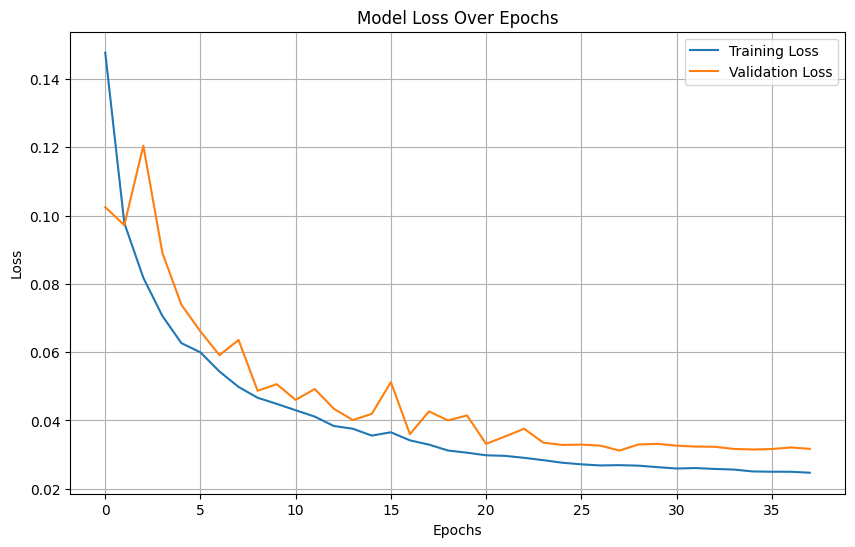

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

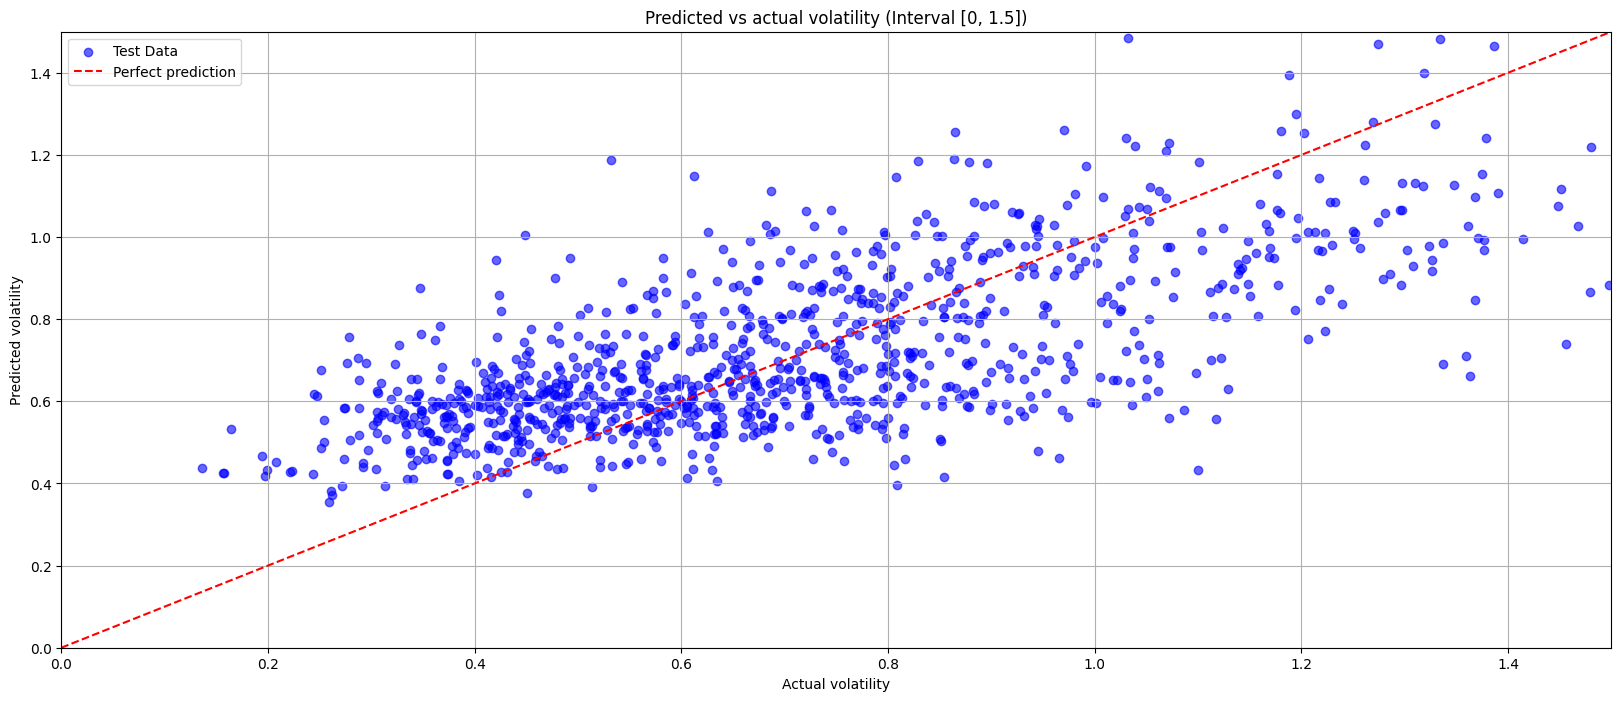

In [17]:
plt.figure(figsize=(20, 8))
plt.scatter(y_test_lstm, y_pred, alpha=0.6, label='Test Data', color='blue')

max_value = max(1.5, 1.5) 
min_value = max(0, 0)
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Perfect prediction')

plt.xlim(0, 1.5)
plt.ylim(0, 1.5)

plt.title("Predicted vs actual volatility (Interval [0, 1.5])")
plt.xlabel("Actual volatility")
plt.ylabel("Predicted volatility")
plt.legend()
plt.grid()

plt.show()


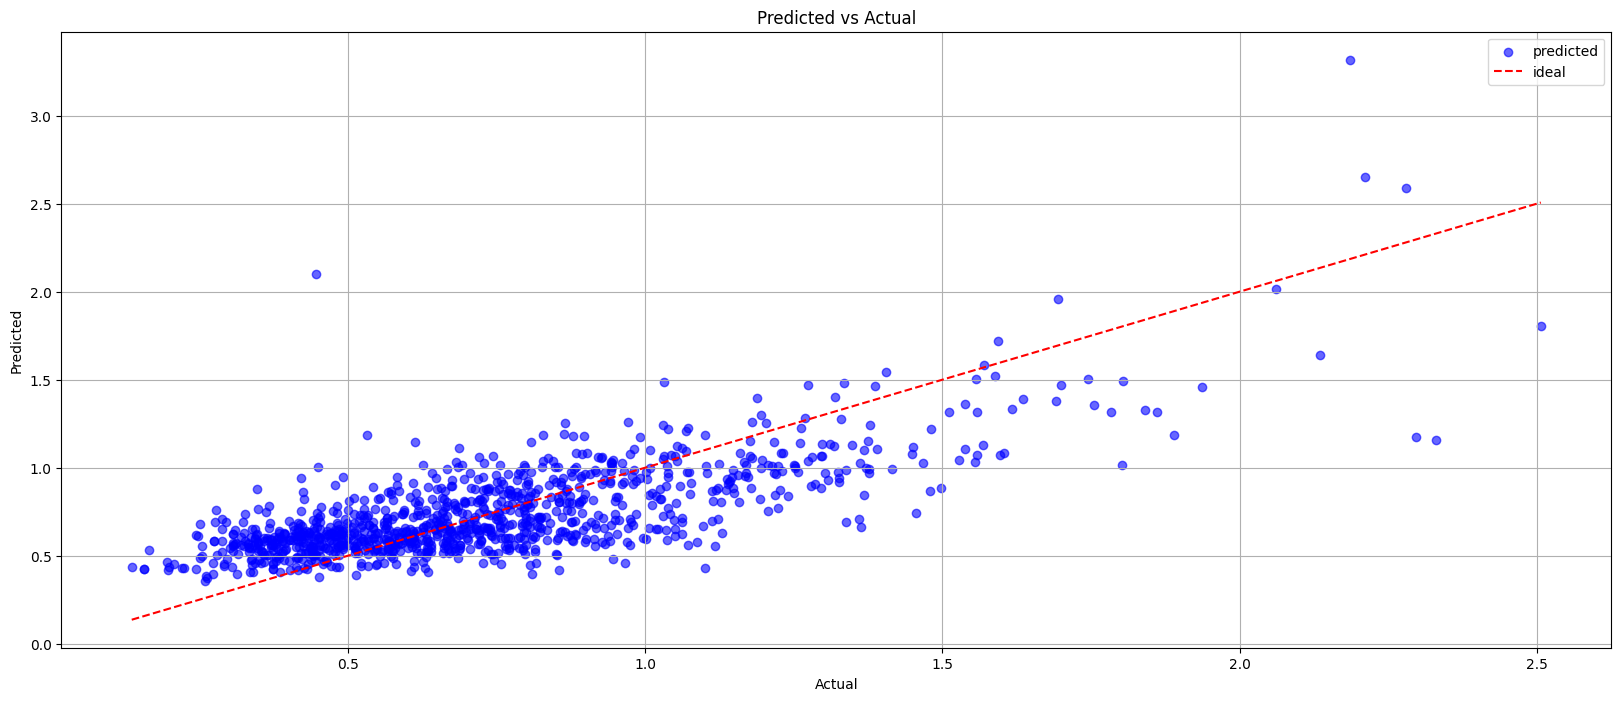

In [18]:
plt.figure(figsize=(20, 8))
plt.scatter(y_test_lstm, y_pred, alpha=0.6, color='blue', label="predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="ideal")
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.show()


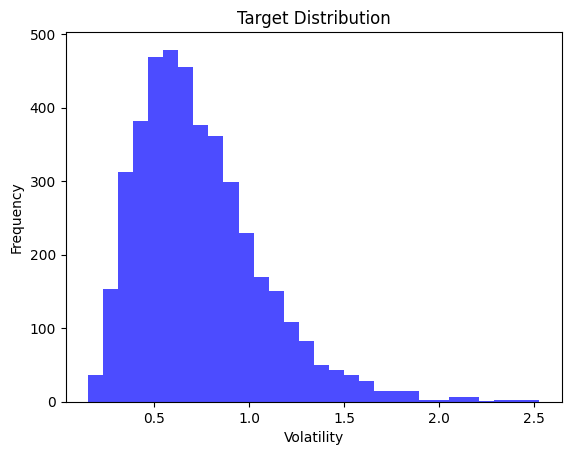

In [19]:
plt.hist(y_train, bins=30, color='blue', alpha=0.7)
plt.title("Target Distribution")
plt.xlabel("Volatility")
plt.ylabel("Frequency")
plt.show()
